# Занятие 5. Кластерный анализ

## Аббакумов В.Л.

In [1]:
import os
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
os.chdir("C:/Users/HP/Documents/analysis/Marketing/data/")

Иерархическая кластеризация
=============

Полезные ссылки:
* https://docs.scipy.org/doc/scipy-0.14.0/reference/cluster.hierarchy.html
* https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
* http://scikit-learn.org/stable/modules/clustering.html

Пример 1. Beverage
--------

Проанализировать данные о безалкогольных напитках. В файле содержатся данные о том, какие напитки пили опрашиваемые из фокус-группы.

In [3]:
df = pd.read_csv("beverage_r.csv", sep=";", index_col='numb.obs')

In [4]:
df.head()

,COKE,D_COKE,D_PEPSI,D_7UP,PEPSI,SPRITE,TAB,SEVENUP
numb.obs,,,,,,,,
1,1,0,0,0,1,1,0,1
2,1,0,0,0,1,0,0,0
3,1,0,0,0,1,0,0,0
4,0,1,0,1,0,0,1,0
5,1,0,0,0,1,0,0,0


Применим алгоритм иерархической кластеризации и построим дендрограмму. Все необходимые вычисления проводятся в функции linkage. Кроме самих данных, ей нужно передать на вход два аргумента: метод вычисления расстояний между кластерами (```ward```, ```single```, ```complete```, ```average```) и метрику (```euclidean``` (default), ```cityblock``` aka Manhattan, ```hamming```, ```cosine```). См. [документацию]( https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html).

In [5]:
# Объект, в котором будет хранится информация о последовательном слиянии кластеров
link = linkage(df, 'ward', 'euclidean')

Объект ```link``` представляет собой матрицу ```(n-1) x 4```, где ```n``` - число наблюдений. Каждая строка матрицы представляет собой результат слияния очередной пары кластеров с номерами ```link[i, 0]``` и ```link[i, 1]```. Новому кластеру присваивается номер ```n + i```. ```link[i, 2]``` означает расстояние между слитыми кластерами, а ```link[i, 3]``` - размер нового кластера.

In [6]:
link[:5]

array([[ 5., 10.,  0.,  2.],
       [ 1.,  2.,  0.,  2.],
       [ 4., 35.,  0.,  3.],
       [ 3., 22.,  0.,  2.],
       [20., 36.,  0.,  4.]])

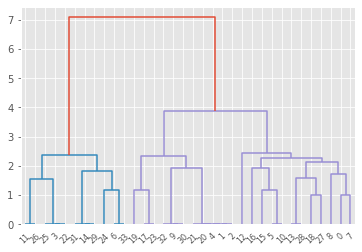

In [7]:
# Функция для построения дендрограммы
dn = dendrogram(link)

Алгоритм подкрасил в дендрограмме два кластера, но здесь, скорее, кластера всё-таки три. Теперь хочется посмотреть, какими характеристиками различаются наши кластеры.

Сначала добавим к данным колонку ```cluster```, в которую запишем номер кластера, в которую попал объект. Это сделаем с помощью функции ```fcluster```. В качестве первого аргумента передаём объект ```linkage```, полученный выше. Третьим аргументом ```criterion``` передаём критерий для разбиения на кластеры (```distance``` для остановки разбиения по расстоянию между кластерами и ```maxclust``` для разбиения по заданному числу кластеров). Вторым же аргументом является либо пороговое значение для расстояния между кластерами, либо количество кластеров, в зависимости от аргумента ```criterion```.

In [8]:
# Останавливаем объединение, если кластеров 2
df['cluster'] = fcluster(link, 2, criterion='maxclust')

In [9]:
df.groupby('cluster').mean()

,COKE,D_COKE,D_PEPSI,D_7UP,PEPSI,SPRITE,TAB,SEVENUP
cluster,,,,,,,,
1,0.000000,1.00000,0.545455,0.545455,0.000000,0.000000,0.909091,0.000000
2,0.869565,0.26087,0.086957,0.043478,0.695652,0.478261,0.043478,0.391304


Дадим названия кластерам:
* 1 кластер - физкультурники, ведущие здоровый образ жизни.
* 2 кластер - либо люди без пристрастий, либо малый объем выборки не позволяет их разделить на группы.

In [10]:
# Останавливаем объединение, если расстояние между кластерами превышает 3
df['cluster'] = fcluster(link, 3, criterion='distance')

Теперь вычислим средние значения всех характеристик, сгруппировав данные по номеру кластера. Используем стандартную конструкцию: вызов метода ```groupby``` с последующим применением группирующей функции.

In [11]:
df.groupby('cluster').mean()

,COKE,D_COKE,D_PEPSI,D_7UP,PEPSI,SPRITE,TAB,SEVENUP
cluster,,,,,,,,
1,0.00,1.000000,0.545455,0.545455,0.000000,0.000000,0.909091,0.000000
2,1.00,0.272727,0.090909,0.000000,1.000000,0.000000,0.000000,0.272727
3,0.75,0.250000,0.083333,0.083333,0.416667,0.916667,0.083333,0.500000


Дадим названия кластерам:
* 1 кластер - физкультурники, ведущие здоровый образ жизни.
* 2 кластер - традиционалисты, любящие коричневое.
* 3 кластер - либо люди без пристрастий, либо малый объем выборки не позволяет их разделить на группы.

Если мы выберем 2 кластера, то получим физкультурников и людей без предпочтений, т.е. мы потеряем люителей колы. Таким образом 3 кластера - информативней. При выборе количества кластеров опираемся на интерпретацию.

Также интересно узнать, сколько наблюдений попало в каждый кластер. Для этого также применяем вызов ```groupy``` с последующим применением метода ```size```.

In [12]:
df.groupby('cluster').size()

cluster
1    11
2    11
3    12
dtype: int64

**Каменистая осыпь**

А можно было выбрать число кластеров не на глаз по дендрограмме, а автоматически, тем более если данных много? Можно. Построим график, носящий название "каменистая осыпь". Напомним, в матрице ```link``` во второй колонке хранятся расстояния между парами слитых кластеров. По построению, строки матрицы упорядочены по этой колонке.

In [13]:
dist = link[:, 2]
dist

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 1.        , 1.15470054, 1.15470054, 1.15470054,
       1.54919334, 1.58113883, 1.73205081, 1.82574186, 1.91485422,
       1.93649167, 2.12132034, 2.27636073, 2.33711814, 2.37920282,
       2.446395  , 3.87646865, 7.09212963])

Таким образом, можно построить график зависимости расстояний между кластерами от шага слияния (обратного), и посмотреть, начиная с какого момента это расстояние перестанет значительно меняться.

Text(22, 2.6, '4 clusters')

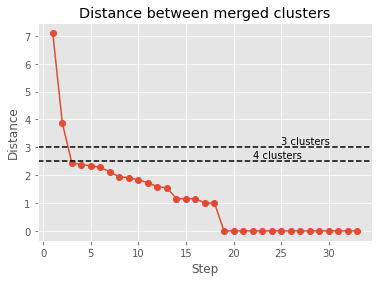

In [14]:
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)
plt.plot(idxs, dist_rev, marker='o')
plt.title('Distance between merged clusters')
plt.xlabel('Step')
plt.ylabel('Distance')
plt.axhline(3, c='k', linestyle='dashed')
plt.axhline(2.52, c='k', linestyle='dashed')
plt.text(25, 3.1, '3 clusters')
plt.text(22, 2.6, '4 clusters')

Из картинки видно, что если мы остановимся объединять кластеры при расстоянии равном примерно 2.5, мы получим 4 кластера, а при равном 3 - 3 кластера.

Однако, строго говоря, этот способ всё ещё немасштабируем для больших данных. Но его можно просто поправить, включая в график не все подряд слияния, а только несколько последних. И если уж мы совсем хотим автомаизировать процесс, то факт сильного изменения расстояний между кластерами можно фиксировать с помощью производной: там где график выходит на горизонталь, производная станет почти нулём.

Пример 2. Кластеризация претендентов
----------------------

Рассмотрим данные о приеме на работу на некоторое предприятие. 18 претендентов прошли 10 различных тестов в кадровом отделе. Максимальная оценка, которую можно было получить за каждый из тестов, составляет 10 баллов, минимальная - 1 балл.Проверялись следующие качества:
1. Память на числа.
2. Умение решать математические задачи.
3. Находчивость при прямом диалоге.
4. Умение составлять алгоритмы.
5. Уверенность во время выступления.
6. Командный дух.
7. Находчивость.
8. Сотрудничество.
9. Признание в коллективе.
10. Сила убеждения.

In [15]:
df = pd.read_csv('assess.dat', sep='\t', index_col='NAME')
df.head()

,NR,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
NAME,,,,,,,,,,,
Volker,1,10,10,9,10,10,10,9,10,10,9
Sigrid,2,10,10,4,10,5,5,4,5,4,3
Elmar,3,5,4,10,5,10,4,10,5,3,10
Peter,4,10,10,9,10,10,10,9,10,10,9
Otto,5,4,3,5,4,3,10,4,10,10,5


In [16]:
# В колонке NR находится номер объекта, его нужно исключить из данных для кластеризации
del df['NR']

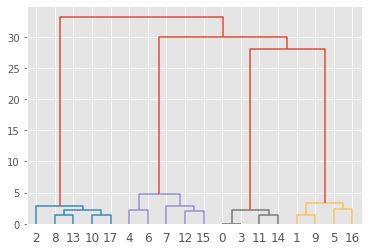

In [17]:
link = linkage(df, 'ward', 'euclidean')
dn = dendrogram(link)

In [18]:
df['cluster'] = fcluster(link, 4, criterion='maxclust')

In [19]:
df.groupby('cluster').mean()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
cluster,,,,,,,,,,
1,4.2,4.8,10.00,4.4,10.00,4.4,10.00,4.00,3.80,10.00
2,4.8,4.4,4.00,4.0,4.20,10.0,4.40,10.00,10.00,5.00
3,10.0,10.0,9.00,10.0,10.00,9.5,9.25,9.75,10.00,9.50
4,10.0,10.0,4.25,10.0,4.75,4.5,3.75,4.25,4.25,4.25


Интерпретация кластеров:
* Кластер 1 - продажники.
* Кластер 2 - исполнители (работа в коллективе).
* Кластер 3 - отличники.
* Кластер 4 - аналитики.

Пример 3. Потребление протеинов в Европе
------------------

В файле представлены данные о том, как питаются люди в разных странах Европы, а именно сколько потребляют протеинов через предпочитаемые продукты. Виды продуктов:
* RedMeat - красное мясо;
* WhiteMeat - птица;
* Eggs - яйца;
* Milk - молоко;
* Fish - рыба;
* Cereals - хлебо-булочные изделия;
* Starch - макароны, крахмал;
* Nuts - орехи;
* Fr&Veg - фрукты и овощи.

In [20]:
df = pd.read_csv('Protein Consumption in Europe.csv', sep=';', decimal=',', index_col='Country')
df.head()

,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg
Country,,,,,,,,,
Albania,10.1,1.4,0.5,8.9,0.2,42.3,0.6,5.5,1.7
Austria,8.9,14.0,4.3,19.9,2.1,28.0,3.6,1.3,4.3
Belgium,13.5,9.3,4.1,17.5,4.5,26.6,5.7,2.1,4.0
Bulgaria,7.8,6.0,1.6,8.3,1.2,56.7,1.1,3.7,4.2
Czechoslovakia,9.7,11.4,2.8,12.5,2.0,34.3,5.0,1.1,4.0


Стандартизация данных
--------------------
В этом примере данные, которые мы собираемся кластеризовать, хотя и находятся в одних и тех же единицах измерения, но местами они различаются почти на два порядка, так что будет не лишним их стандартизировать перед анализом. 

В модуле preprocessing библиотеки sklearn реализованы несколько классов стандартизации данных:
* StandardScaler - приведение к нулевому среднему и единичной дисперсии.
* MinMaxScaler - приведение данных к отрезку [0, 1].
* MaxAbsScaler - приведение к [-1, 1] (рекомендуется для разреженных данных).

Замечание. У этих методов есть чуть более лёгкие методы-аналоги ```scale```, ```minmax_scale``` и ```maxabs_scale```, которые делают практически то же самое, но для supervized задач машинного обучения, которые встретяся позже, удобнее использовать именно изначально указанные классы.

Процесс стандартизации выглядит так:

In [21]:
# Выбираем один из вариантов нормализации
norm = preprocessing.StandardScaler()
# norm = preprocessing.MaxAbsScaler()
# norm = preprocessing.MinMaxScaler()

# вычисляем параметры нормализации (они будут сохранены внутри объекта norm)
norm.fit(df)
# преобразовываем данные с параметрами
X = norm.transform(df)
# Полученный на предыдущем шаге объект X - это матрица класса numpy.ndarray.
# Глазами на неё смотреть неудобно, лучше преобразовать её в объект класса pandas.DataFrame.
X = pd.DataFrame(X, index=df.index, columns=df.columns)

In [22]:
X.head()

,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg
Country,,,,,,,,,
Albania,0.082941,-1.794750,-2.224584,-1.179570,-1.225033,0.934804,-2.295965,1.247968,-1.378251
Austria,-0.282974,1.686446,1.245621,0.400468,-0.655111,-0.395051,-0.422218,-0.910790,0.092789
Belgium,1.119699,0.387905,1.062979,0.055732,0.064791,-0.525246,0.889405,-0.499598,-0.076947
Bulgaria,-0.618396,-0.523837,-1.220051,-1.265754,-0.925074,2.273959,-1.983674,0.322786,0.036210
Czechoslovakia,-0.039031,0.968104,-0.124197,-0.662467,-0.685107,0.190830,0.452198,-1.013588,-0.076947


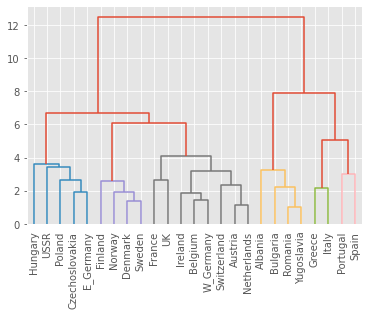

In [23]:
link = linkage(X, 'ward', 'euclidean')
dn = dendrogram(link,
                # массив с названиями объектов для подписи по оси X
                labels=X.index.tolist(),
                # опция для более красивого отображения слишком ветввистой дендрограммы
                truncate_mode='lastp',
                # повернуть подписи вертикально
                color_threshold=5,
                leaf_rotation=90.)

In [24]:
df['cluster'] = fcluster(link, 4, criterion='maxclust')

In [25]:
df.groupby('cluster').mean()

,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg
cluster,,,,,,,,,
1,7.920000,10.040000,2.840000,13.84,2.740000,35.740,5.560000,2.540000,4.260000
2,12.091667,9.441667,3.708333,23.00,4.991667,24.025,4.616667,1.766667,3.491667
3,7.125000,4.675000,1.200000,9.45,0.750000,51.125,1.950000,5.050000,2.975000
4,8.125000,3.800000,2.475000,11.20,7.625000,33.675,3.975000,5.675000,7.075000


Интерпретация кластеров:
* Кластер 1 - центрально-европейские страны (обилие мясных, овощных блюд, изделий из пшеничной муки)
* Кластер 2 - северные страны (рыба, мясо, богатые жирами)
* Кластер 3 - средиземноморская диета (мало яиц и рыбы, много фруктов и хлебо-булочной продукции)
* Кластер 4 - южные страны (фрукты, овощи, орехи, рыба)

Кластеризация методом k-means (k-средних)
=============

Полезные ссылки:
* http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
* http://scikit-learn.org/stable/modules/clustering.html

Пример 1. Beverage
--------

In [26]:
df = pd.read_csv("beverage_r.csv", sep=";", index_col='numb.obs')
df.head()

,COKE,D_COKE,D_PEPSI,D_7UP,PEPSI,SPRITE,TAB,SEVENUP
numb.obs,,,,,,,,
1,1,0,0,0,1,1,0,1
2,1,0,0,0,1,0,0,0
3,1,0,0,0,1,0,0,0
4,0,1,0,1,0,0,1,0
5,1,0,0,0,1,0,0,0


В scikit-learn процедура настройки и использования моделей часто проходит по одной и той же схеме:
1. Инициализация модели, задание её параметров,
2. Подгонка модели (метод fit и/или fit_transform),
3. Предсказание для новых наблюдений (метод predict).

Для кластеризации методом k-means необходимо задать k наперёд. Попробуем k = 2. 

In [27]:
# инициализация модели
model = KMeans(n_clusters=2, random_state=42)
# random_state - зерно датчика случайных чисел. 
# При каждом новом вызове с одинаковыми random_state модель будет давать
# одинаковые результаты.

In [28]:
# подгонка модели по данным из df
model.fit(df)

KMeans(n_clusters=2, random_state=42)

In [29]:
# Результат кластеризации на данных df
model.labels_

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1])

In [30]:
# координаты центров кластеров
model.cluster_centers_

array([[ 9.52380952e-01,  2.38095238e-01,  4.76190476e-02,
        -8.32667268e-17,  7.61904762e-01,  4.28571429e-01,
         4.76190476e-02,  3.80952381e-01],
       [ 1.11022302e-16,  9.23076923e-01,  5.38461538e-01,
         5.38461538e-01, -5.55111512e-17,  1.53846154e-01,
         7.69230769e-01,  7.69230769e-02]])

In [31]:
# предсказание для новых наблюдений. Метод predict.
new_items = [
    [1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0]
]
model.predict(new_items)

array([1, 0])

Модель выше разбивала на два кластера. 
Как определить число кластеров?
Применим модель для разного числа кластеров, чтобы построить график каменистой осыпи. Метод ```inertia_``` вернёт сумму расстояний от каждой точки данных до центра ближайшего к ней кластера. Таким образом, кластеризацию можно считать условно хорошей, когда инерция перестаёт сильно уменьшаться при увеличении числа кластеров.

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


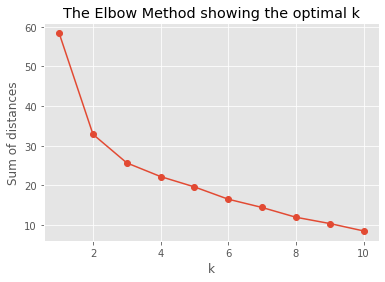

In [32]:
K = range(1, 11)
models = [KMeans(n_clusters=k, random_state=42).fit(df) for k in K]
dist = [model.inertia_ for model in models]

# Plot the elbow
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Ранее мы решили, что три кластера - это оптимальный выбор. Теперь хочется посмотреть на список наблюдений, составляющий данные кластеры, и посмотреть, чем они отличаются друг от друга. Для этого применим метод ```labels_```, а затем посчитаем средние значения факторов для каждого кластера.

In [33]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(df)
df['cluster'] = model.labels_
df.groupby('cluster').mean()

,COKE,D_COKE,D_PEPSI,D_7UP,PEPSI,SPRITE,TAB,SEVENUP
cluster,,,,,,,,
0,0.727273,0.272727,0.090909,0.090909,0.454545,1.0,0.090909,0.454545
1,0.000000,1.000000,0.545455,0.545455,0.000000,0.0,0.909091,0.000000
2,1.000000,0.250000,0.083333,0.000000,0.916667,0.0,0.000000,0.333333


In [34]:
df.groupby('cluster').size()

cluster
0    11
1    11
2    12
dtype: int64

Пример 2. Кластеризация претендентов
-------

In [35]:
df = pd.read_csv('assess.dat', sep='\t', index_col='NAME')
df.head()

,NR,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
NAME,,,,,,,,,,,
Volker,1,10,10,9,10,10,10,9,10,10,9
Sigrid,2,10,10,4,10,5,5,4,5,4,3
Elmar,3,5,4,10,5,10,4,10,5,3,10
Peter,4,10,10,9,10,10,10,9,10,10,9
Otto,5,4,3,5,4,3,10,4,10,10,5


In [36]:
# В колонке NR находится номер объекта, его нужно исключить из данных для кластеризации
del df['NR']

In [37]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(df)
df['cluster'] = model.labels_
df.groupby('cluster').mean()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
cluster,,,,,,,,,,
0,4.8,4.4,4.00,4.0,4.20,10.0,4.40,10.00,10.00,5.00
1,4.2,4.8,10.00,4.4,10.00,4.4,10.00,4.00,3.80,10.00
2,10.0,10.0,4.25,10.0,4.75,4.5,3.75,4.25,4.25,4.25
3,10.0,10.0,9.00,10.0,10.00,9.5,9.25,9.75,10.00,9.50


Пример 3. Потребление протеинов в Европе
---------------------

In [38]:
df = pd.read_csv('Protein Consumption in Europe.csv', sep=';', decimal=',', index_col='Country')
df.head()

,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg
Country,,,,,,,,,
Albania,10.1,1.4,0.5,8.9,0.2,42.3,0.6,5.5,1.7
Austria,8.9,14.0,4.3,19.9,2.1,28.0,3.6,1.3,4.3
Belgium,13.5,9.3,4.1,17.5,4.5,26.6,5.7,2.1,4.0
Bulgaria,7.8,6.0,1.6,8.3,1.2,56.7,1.1,3.7,4.2
Czechoslovakia,9.7,11.4,2.8,12.5,2.0,34.3,5.0,1.1,4.0


In [39]:
# Стандартизируем данные
norm = preprocessing.StandardScaler()
norm.fit(df)
X = norm.transform(df)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


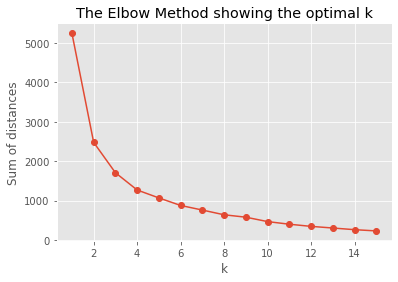

In [40]:
K = range(1, 16)
models = [KMeans(n_clusters=k).fit(df) for k in K]
dist = [model.inertia_ for model in models]

# Plot the elbow
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [41]:
model = KMeans(n_clusters=4)
model.fit(df)
df['cluster'] = model.labels_
df.groupby('cluster').mean()

,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg
cluster,,,,,,,,,
0,8.400000,7.783333,2.700000,14.90,2.933333,38.766667,4.266667,4.000000,5.150000
1,12.091667,9.441667,3.708333,23.00,4.991667,24.025000,4.616667,1.766667,3.491667
2,7.125000,4.675000,1.200000,9.45,0.750000,51.125000,1.950000,5.050000,2.975000
3,7.233333,6.233333,2.633333,8.20,8.866667,26.933333,6.033333,3.800000,6.233333


In [42]:
df['cluster'].sort_values()

Country
Italy             0
Poland            0
USSR              0
Czechoslovakia    0
Hungary           0
Greece            0
Norway            1
Netherlands       1
W_Germany         1
Ireland           1
France            1
Finland           1
UK                1
Denmark           1
Belgium           1
Austria           1
Switzerland       1
Sweden            1
Albania           2
Romania           2
Bulgaria          2
Yugoslavia        2
Portugal          3
E_Germany         3
Spain             3
Name: cluster, dtype: int32

Интерпретация кластеров:
* Кластер 1 - центрально-европейские страны (обилие мясных, овощных блюд, изделий из пшеничной муки)
* Кластер 2 - северные страны (рыба, мясо, богатые жирами)
* Кластер 3 - средиземноморская диета (мало яиц и рыбы, много фруктов и хлебо-булочной продукции)
* Кластер 4 - южные страны (фрукты, овощи, орехи, рыба)